In [1]:
  """
    SSA generates a trajectory matrix X from the original series y
    by sliding a window of length dim. The trajectory matrix is aproximated
    using SVD. The last step reconstructs the series from the aproximated trajectory matrix.
"""

import scipy.linalg as linalg
import scipy.stats as stats
import numpy as np

try:
    from matplotlib import pyplot as plt
    import pylab
except:
    print("Plotting functions will be disabled. Can't import matplotlib")
    pass


def isscalar(x):
    """
    Returns true if x is scalar value
    :param x:
    :return:
    """
    return not isinstance(x, (list, tuple, dict, np.ndarray))


def nans(dims):
    """
    nans((M,N,P,...)) is an M-by-N-by-P-by-... array of NaNs.
    :param dims: dimensions tuple
    :return: nans matrix
    """
    return np.nan * np.ones(dims)


def ssa(y, dim) -> tuple:
    """
    Singular Spectrum Analysis decomposition for a time series
    Example:
    -------
    >>> import numpy as np
    >>>
    >>> x = np.linspace(0, 5, 1000)
    >>> y = 2*x + 2*np.sin(5*x) + 0.5*np.random.randn(1000)
    >>> pc, s, v = ssa(y, 15)
    :param y: time series (array)
    :param dim: the embedding dimension
    :return: (pc, s, v) where
             pc is the matrix with the principal components of y
             s is the vector of the singular values of y given dim
             v is the matrix of the singular vectors of y given dim
    """
    n = len(y)
    t = n - (dim - 1)

    yy = linalg.hankel(y, np.zeros(dim))
    yy = yy[:-dim + 1, :] / np.sqrt(t)

    # here we use gesvd driver (as in Matlab)
    _, s, v = linalg.svd(yy, full_matrices=False, lapack_driver='gesvd')

    # find principal components
    vt = np.matrix(v).T
    pc = np.matrix(yy) * vt

    return np.asarray(pc), s, np.asarray(vt)


def inv_ssa(pc: np.ndarray, v: np.ndarray, k) -> np.ndarray:
    """
    Series reconstruction for given SSA decomposition using vector of components
    Example:
    -------
    >>> import numpy as np
    >>> from matplotlib import pyplot as plt
    >>> x = np.linspace(0, 5, 1000)
    >>> y = 2*x + 2*np.sin(5*x) + 0.5*np.random.randn(1000)
    >>> pc, s, v = ssa(y, 15)
    >>>
    >>> yr = inv_ssa(pc, v, [0,1])
    >>> plt.plot(x, yr)
    :param pc: matrix with the principal components from SSA
    :param v: matrix of the singular vectors from SSA
    :param k: vector with the indices of the components to be reconstructed
    :return: the reconstructed time series
    """
    if isscalar(k): k = [k]

    if pc.ndim != 2:
        raise ValueError('pc must be a 2-dimensional matrix')

    if v.ndim != 2:
        raise ValueError('v must be a 2-dimensional matrix')

    t, dim = pc.shape
    n_points = t + (dim - 1)

    if any(filter(lambda x: dim < x or x < 0, k)):
        raise ValueError('k must be vector of indexes from range 0..%d' % dim)

    pc_comp = np.asarray(np.matrix(pc[:, k]) * np.matrix(v[:, k]).T)

    xr = np.zeros(n_points)
    times = np.zeros(n_points)

    # reconstruction loop
    for i in range(dim):
        xr[i : t + i] = xr[i : t + i] + pc_comp[:, i]
        times[i : t + i] = times[i : t + i] + 1

    xr = (xr / times) * np.sqrt(t)
    return xr


def ssa_predict(x, dim, k, n_forecast, e=None, max_iter=10000) -> np.ndarray:
    """
    Series data prediction based on SSA
    Example:
    >>> x = np.linspace(0,5,1000)
    >>> y = 2*x + 2*np.sin(5*x) + 0.5*np.random.randn(1000)
    >>>
    >>> # make prediction for next 200 points
    >>> ys = ssa_predict(y, 100, [0,1,2], 200, 0.01)
    >>> 
    >>> # plot prediction
    >>> plt.figure(figsize=(16,8));
    >>> x0 = len(y); plt.plot(range(x0), y); plt.plot(range(x0, x0 + len(ys)), ys, 'r--')
    >>> plt.legend(['Data', 'Forecast'])
    :param x: series to be predicted
    :param dim: the embedding dimension
    :param k: components indexes for reconstruction
    :param n_forecast: number of points to forecast
    :param e: minimum value to ensure convergence
    :param max_iter: maximum number of iterations
    :return: forecasted series
    """
    if not e:
        e = 0.0001 * (np.max(x) - np.min(x))
    mean_x = x.mean()
    x = x - mean_x
    xf = nans(n_forecast)

    for i in range(n_forecast):
        # here we use previous value as initial estimation
        x = np.append(x, x[-1])
        yq = x[-1]
        y = yq + 2 * e
        n_iter = max_iter
        while abs(y - yq) > e:
            yq = x[-1]

            pc, _, v = ssa(x, dim)
            xr = inv_ssa(pc, v, k)
            print(xr.shape)

            y = xr[-1]
            x[-1] = y
            n_iter -= 1
            if n_iter <= 0:
                print('ssa_predict> number of iterations exceeded')
                break

        xf[i] = x[-1]
    xf = xf + mean_x
    return xf


def ssa_cutoff_order(x: np.ndarray, dim=200, cutoff_pctl=75, show_plot=False):
    """
    Tries to find best cutoff for number of order when increment changes of informational entropy
    becomes little and the effective information saturates.
    :param x: series
    :param dim: embedding dimensions (200 by default)
    :param cutoff_pctl: percentile of changes (75%)
    :param show_plot: true if we need to see informational curve
    :return: cutoff number
    """
    _, s, _ = ssa(x, dim)
    curve = -s/s.sum() * np.log(s/s.sum())
    pctl = np.percentile(curve, cutoff_pctl)
    n_cutoff = sum(curve > pctl)
    
    if show_plot:
        plt.plot(curve)
        plt.ylabel('Increment of Singular Entropy')
        plt.xlabel('Number of Order')
        plt.vlines(n_cutoff, 0, max(curve), 'g', linestyles='dotted')
        plt.text(dim*0.6, max(curve)*0.9, 'Cutoff order: %d' % n_cutoff)
        
    return n_cutoff


def ssaview(y, dim, k):
    """
    Visualising tools for singular spectrum analysis
    Example:
    -------
    >>> import numpy as np
    >>>
    >>> x = np.linspace(0, 5, 1000)
    >>> y = 2*x + 2*np.sin(5*x) + 0.5*np.random.randn(1000)
    >>> ssaview(y, 15, [0,1])
    :param y: series
    :param dim: the embedding dimension
    :param k: components indexes for reconstrunction
    """
    pc, s, v = ssa(y, dim)
    yr = inv_ssa(pc, v, k)

    plt.subplot2grid((3, 3), (0, 0), rowspan=2, colspan=2)
    plt.title('Singular Spectrum View for %d window length' % dim)
    plt.plot(y, color='#6ec0fa', lw=1.2)
    plt.plot(yr, 'r', lw=1)
    plt.ylabel('Series')
    plt.legend(['Original', 'Reconstructed'])

    # residuals chart
    plt.subplot2grid((3, 3), (2, 0), colspan=2)
    plt.plot(y - yr, 'g', lw=1)
    plt.ylabel('Residual')
    plt.legend(['Residual'])
    plt.xlabel('Data points')

    # resuduals qq-plot
    plt.subplot2grid((3, 3), (0, 2), rowspan=2)
    stats.probplot(y - yr, dist="norm", plot=pylab)
    plt.title('Residuals QQ plot')

    # singular values
    plt.subplot2grid((3, 3), (2, 2))
    plt.title('Singular spectrum')
    plt.plot(100 * s / s.sum(), 'g', marker='*', lw=1, alpha=0.6)
    plt.xlabel('Eigenvalue number')
    plt.ylabel('Eigenvalue')

In [43]:
import pandas as pd
wine = pd.read_csv('wine.dat', sep='\t', index_col=-1)[:-1]
wine[wine.columns[:-1]] = wine[wine.columns[:-1]].astype(int)
wine.index = pd.to_datetime(wine.index)
F = wine.total.values

In [49]:
y_train, y_test = F[:150], F[150:]

In [72]:
ys = ssa_predict(y_train, 84, list(range(10)), 24, 0.01)

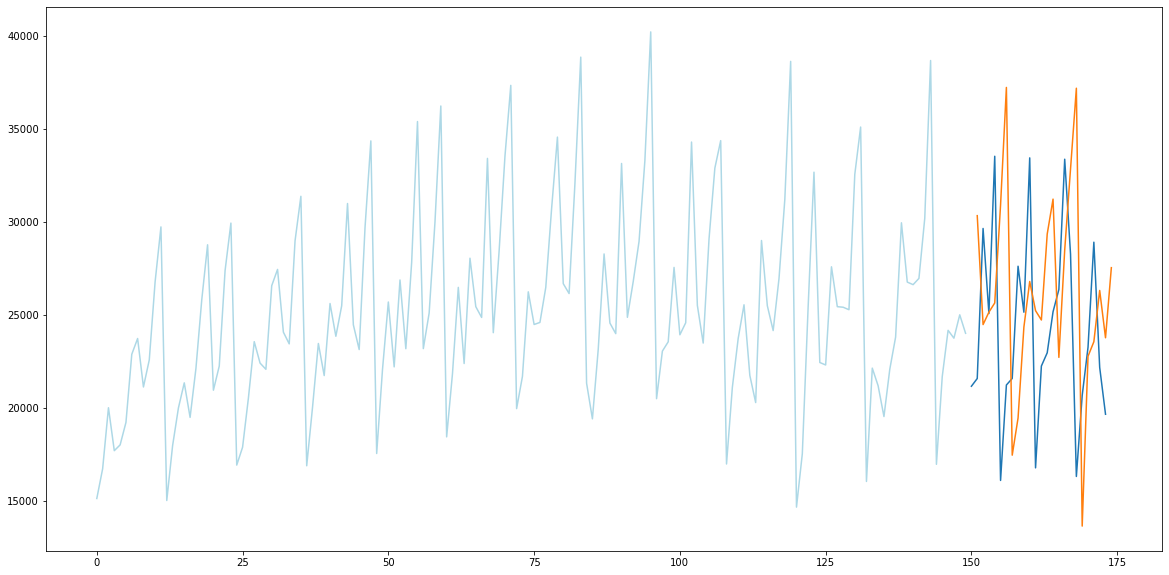

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(y_train, color='lightblue')
ax.plot(range(150, 174), ys)
ax.plot(range(151, 175), y_test)

In [2]:
x = np.linspace(0,5,1000)

In [3]:
y = 2 * x + 2 * np.sin(5 * x) + 0.5*np.random.randn(1000)

In [4]:
s = """
:param x: series to be predicted
:param dim: the embedding dimension
:param k: components indexes for reconstruction
:param n_forecast: number of points to forecast
:param e: minimum value to ensure convergence
:param max_iter: maximum number of iterations
:return: forecasted series
"""

In [7]:
ys = ssa_predict(y, 50, [0, 1, 2], 10, 0.01)

(1001,)
(1001,)
(1001,)
(1002,)
(1002,)
(1003,)
(1003,)
(1004,)
(1004,)
(1005,)
(1005,)
(1005,)
(1006,)
(1006,)
(1007,)
(1007,)
(1007,)
(1008,)
(1008,)
(1009,)
(1009,)
(1010,)
(1010,)
(1010,)


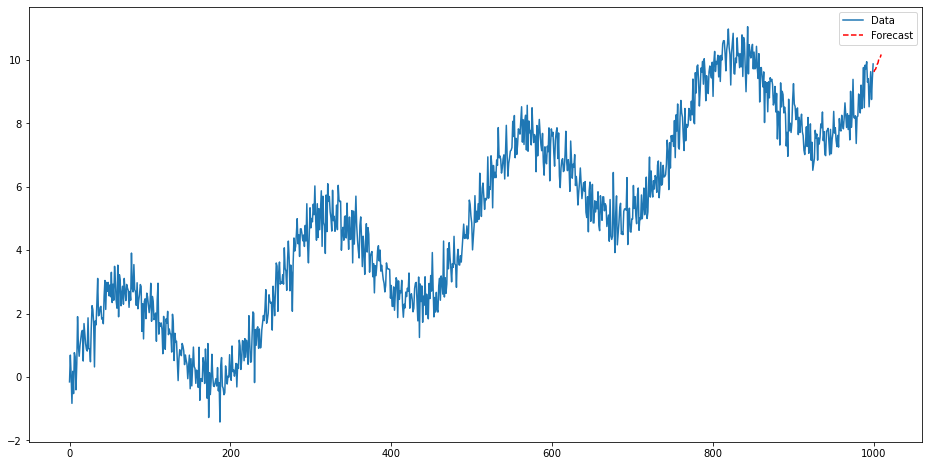

In [8]:
plt.figure(figsize=(16,8))
x0 = len(y)
plt.plot(range(x0), y)
plt.plot(range(x0, x0 + len(ys)), ys, 'r--')
plt.legend(['Data', 'Forecast'])